In [1]:
import random
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np
import webcolors
%matplotlib inline

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = os.path.join(PATH, "images/ds1")

images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

SOURCE_LABELS = os.path.join(PATH, "labels/ds1")

labels = glob(os.path.join(SOURCE_LABELS, "*.png"))

In [3]:
images.sort()
labels.sort()
print(np.size(images))
print(np.size(labels))

80
80


In [4]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)
    
x = np.asarray(x)
y = np.asarray(y)

In [5]:
print(y.min())
print(y.max())

print(x.shape)
print(y.shape)

0
8
(80, 1024, 1280, 3)
(80, 1024, 1280)


In [6]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

In [7]:
def colorize(mask):
    hex_colors = ['#000000','#4A4A4A','#FF0000', '#407700', '#00FF37', '#8B572A', '#0000FF', '#FF7600', '#50E3C2']

    rgb_colors = []

    for hex_color in hex_colors:
        rgb_colors.append(webcolors.hex_to_rgb(hex_color))
        
    colors = np.array(rgb_colors)
        
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

In [8]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 2, figsize=(10, 10))

        ax[0].imshow(image)
        ax[1].imshow(colorize(mask))
    else:
        f, ax = plt.subplots(2, 2, figsize=(10, 10))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(colorize(original_mask))
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(colorize(mask))
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

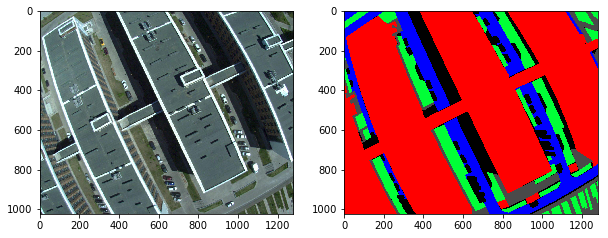

In [9]:
image = x[-1].copy()
mask = y[-1].copy()
visualize(image, mask)

In [10]:
def augment(image, mask):

    original_height, original_width = image.shape[:2]

    aug = Compose([
        RandomSizedCrop(p=0.5, min_max_height=(original_height//2, original_height), height=original_height, width=original_width),
        OpticalDistortion(p=0.5, distort_limit=0.25, shift_limit=0.5),
        OneOf([
            CLAHE(p=1., clip_limit=4.),
            RandomContrast(p=1., limit=0.25),
            RandomGamma(p=1., gamma_limit=(50,200))
            ], p=0.5),
        ])

    augmented = aug(image=image, mask=mask)

    image_heavy = augmented['image']
    mask_heavy = augmented['mask']
    
    return image_heavy, mask_heavy

[0 1 2 4 6]
[0 1 2 4 6]


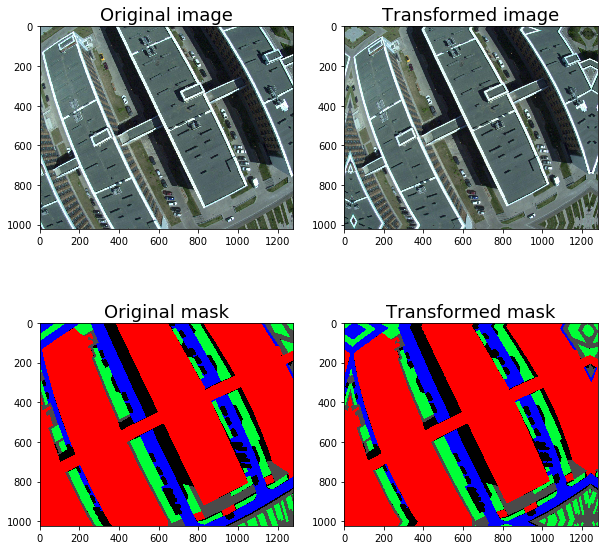

In [11]:
image_heavy, mask_heavy = augment(image, mask)
visualize(image_heavy, mask_heavy, original_image=image, original_mask=mask)
print(np.unique(mask))
print(np.unique(mask_heavy))

In [51]:
import PIL.Image as PIL

for i in range(len(x)):
    image, mask = x[i].copy(), y[i].copy()
    image_heavy, mask_heavy = augment(image, mask)
    PIL.fromarray(image_heavy.astype('uint8'), 'RGB').save(images[i].split(".jpg")[0] + "alb" + ".jpg")
    PIL.fromarray(mask_heavy.astype('uint8'), 'L').save(labels[i].split(".png")[0] + "alb" + ".png")